## Inpainting with Gradient Field

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from utils import *
import os

%matplotlib inline

from time import process_time
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from skimage import filters
from skimage import io, color
from scipy.ndimage import convolve

In [2]:
# Функція пошкоджень
def damage_image(image, damage_ratio=0.1):
    damaged_image = np.copy(image)
    mask = np.random.random(damaged_image.shape[:2]) < damage_ratio
    damaged_image[mask] = 0
    return damaged_image, mask

In [3]:
# Функція відновлення
def inpainting_gradient(image, mask, max_iter=100, tolerance=1e-6):
    inpainted_image = np.copy(image)
    gradient_magnitude = np.gradient(image)[0]
    masked_indices = np.where(mask)

    for _ in range(max_iter):
        prev_image = np.copy(inpainted_image)

        for i, j in zip(*masked_indices):
            if i > 0 and i < image.shape[0]-1 and j > 0 and j < image.shape[1]-1:
                gradient_weight = gradient_magnitude[i, j]
                inpainted_image[i, j] = np.mean([
                    inpainted_image[i-1, j], inpainted_image[i+1, j], inpainted_image[i, j-1], inpainted_image[i, j+1]
                ]) + gradient_weight

        if np.linalg.norm(inpainted_image - prev_image) < tolerance:
            break

    return inpainted_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


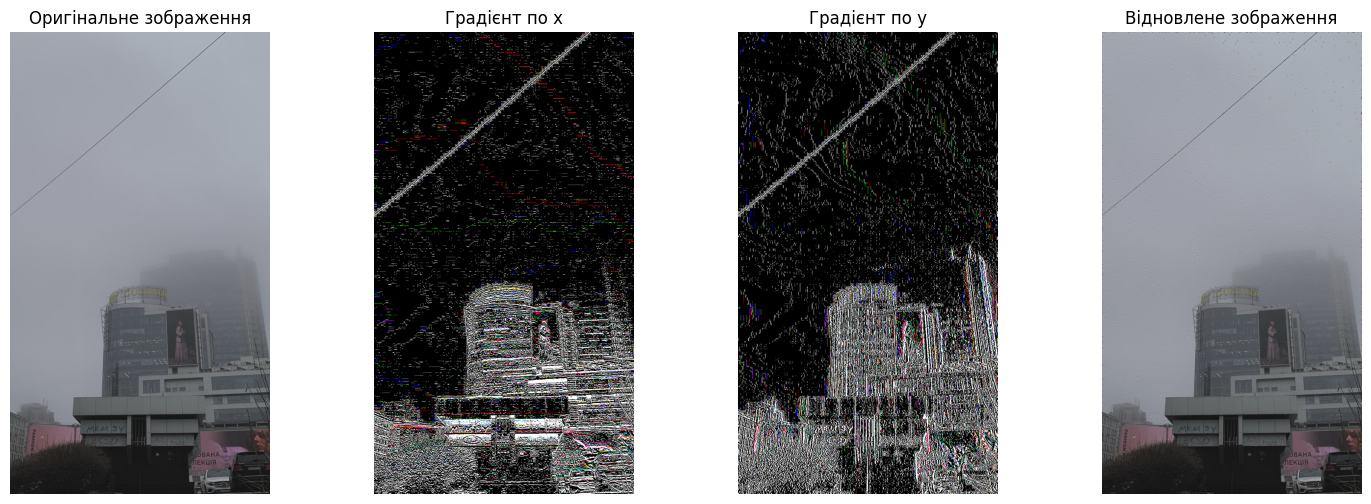

In [4]:
# Завантаження зображення
image_path = "fog.jpg"
image = io.imread(image_path)

# Пошкодження зображення
damaged_image, mask = damage_image(image, damage_ratio=0.1)

# Відновлення зображення
inpainted_image = inpainting_gradient(damaged_image, mask)

# Обчислення градієнту зображення
gradient = np.gradient(image)

# Відображення результатів
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title('Оригінальне зображення')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(gradient[0], cmap='gray')
plt.title('Градієнт по x')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(gradient[1], cmap='gray')
plt.title('Градієнт по y')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(inpainted_image, cmap='gray')
plt.title('Відновлене зображення')
plt.axis('off')

plt.show()


## Gradient Domain Editing Function (least squares method)

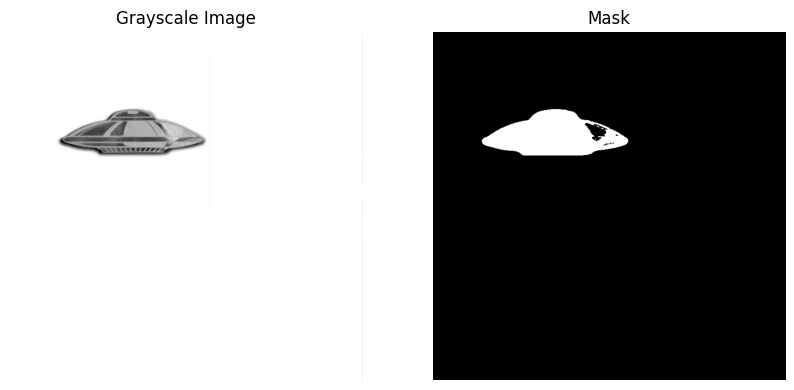

Маска збережена у файл mask.png


In [5]:
# Завантажте зображення
image_path = "ufo.png"
image = io.imread(image_path)

# Видалення альфа-канал, якщо він присутній
if image.shape[-1] == 4:
    image = image[..., :3]

# Перетворення зображення у відтінки сірого
image_gray = color.rgb2gray(image)

# Використання фільтр для покращення контрастності (необов'язково)
image_gray = filters.median(image_gray)

# Застосування порогову бінаризацію для створення маски
threshold = filters.threshold_otsu(image_gray)
mask = image_gray < threshold

# Візуалізація оригінального зображення та маску
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

# Зберегти маску
mask_save_path = "mask.png"
io.imsave(mask_save_path, (mask * 255).astype(np.uint8))
print(f"Маска збережена у файл {mask_save_path}")


In [6]:
# Функція блендингу
def gradient_domain_editing(image, background, binary_mask):
    # Ensure all inputs are float type in the range [0, 1]
    image = image.astype(np.float32) / 255.0
    background = background.astype(np.float32) / 255.0
    binary_mask = binary_mask.astype(np.float32) / 255.0

    if image.shape[:2] != background.shape[:2] or background.shape[:2] != binary_mask.shape:
        print('Please provide images of equal size.')
        return None
    
    blended_image = np.zeros(background.shape, dtype=np.float32)
    
    for i in range(3): # For every channel
        # seems like the toy problem with a couple changes. checks binary_mask.
        image_ = image[:, :, i]
        background_ = background[:, :, i]

        h, w = image_.shape
        im2ind = np.reshape(np.arange(h*w), (h, w))

        e = 0
        A = sparse.lil_matrix((2*h*w + 1, h*w), dtype=np.float32)
        b = np.zeros(2* h * w + 1, dtype=np.float32)
        for y in range(0, h):
            for x in range(0, w):
                if x + 1 < w:
                    if binary_mask[y,x] == 1: # uses image
                        b[e] = image_[y,x] - image_[y,x + 1]
                    else: # uses background
                        b[e] = background_[y,x] - background_[y,x+1]
                    A[e, im2ind[y,x]] = 1
                    A[e, im2ind[y, x + 1]] = -1
                    e = e + 1
                if y + 1 < h:
                    if binary_mask[y,x] == 1:
                        b[e] = image_[y,x] - image_[y + 1,x]
                    else:
                        b[e] = background_[y,x] - background_[y + 1,x]
                    A[e, im2ind[y,x]] = 1
                    A[e, im2ind[y + 1, x ]] = -1
                    e = e + 1
                    
        A[e,im2ind[0,0]] = 1
        b[e] = background_[0,0]
                
        A = A.tocsr()
        v = sparse.linalg.lsqr(A, b)[0]
        v = np.reshape(v, (h, w))

        # changed the for loop for this line of code.
        blended_image[:, :, i] = v

    # Convert the blended image back to 8-bit format
    blended_image = np.clip(blended_image * 255, 0, 255).astype('uint8')
    return blended_image

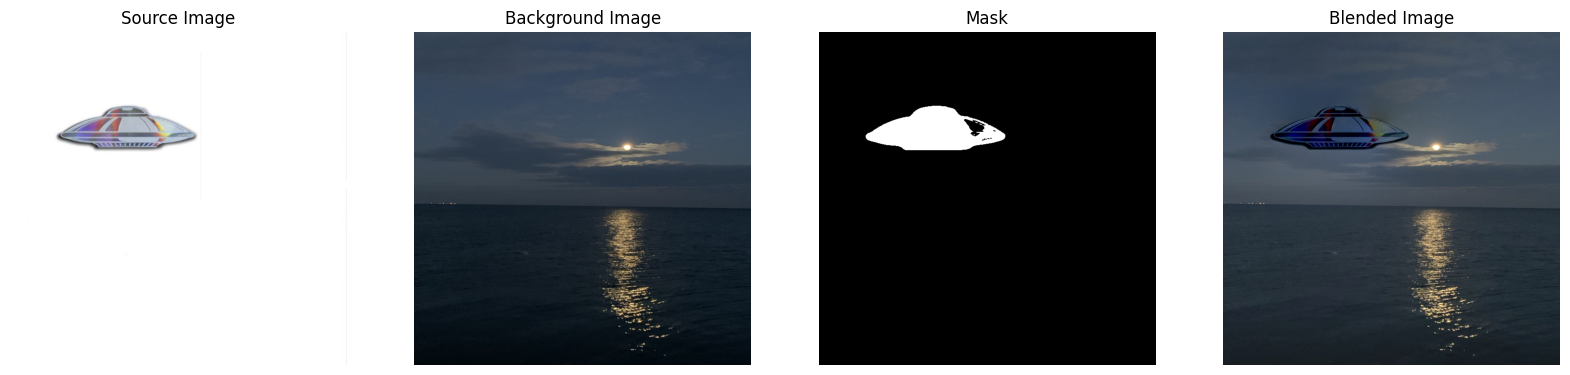

In [7]:
# Зчитати вхідне зображення
image = cv2.cvtColor(cv2.imread('ufo.png'), cv2.COLOR_BGR2RGB)
background = cv2.cvtColor(cv2.imread('sea.jpeg'), cv2.COLOR_BGR2RGB)
mask = cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE)

# Перевірити розмір маски та зображення
if image.shape[:2] != mask.shape:
    # Змінити розмір маски на розмір зображення
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Змінити розмір зображення background на розмір зображення image
background = cv2.resize(background, (image.shape[1], image.shape[0]))

# Застосувати алгоритм gradient domain editing
blended_image = gradient_domain_editing(image, background, mask)

# Відображення результатів
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(image)
axs[0].set_title('Source Image')
axs[0].axis('off')
axs[1].imshow(background)
axs[1].set_title('Background Image')
axs[1].axis('off')
axs[2].imshow(mask, cmap='gray')
axs[2].set_title('Mask')
axs[2].axis('off')
axs[3].imshow(blended_image)
axs[3].set_title('Blended Image')
axs[3].axis('off')
plt.show()


In [8]:
print("Image shape:", image.shape)
print("Background shape:", background.shape)
print("Mask shape:", mask.shape)


Image shape: (727, 736, 3)
Background shape: (727, 736, 3)
Mask shape: (727, 736)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 735.5, 726.5, -0.5)

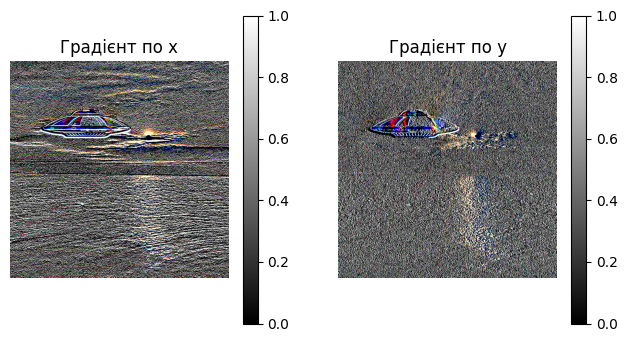

In [9]:
# Обчислюємо чисельні розв'язки градієнтів відновленого зображення
gradient_x = np.gradient(blended_image, axis=0)
gradient_y = np.gradient(blended_image, axis=1)

# Виводимо графіки
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(gradient_x, cmap='gray')
plt.title('Градієнт по x')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gradient_y, cmap='gray')
plt.title('Градієнт по y')
plt.colorbar()
plt.axis('off')


## Cloning

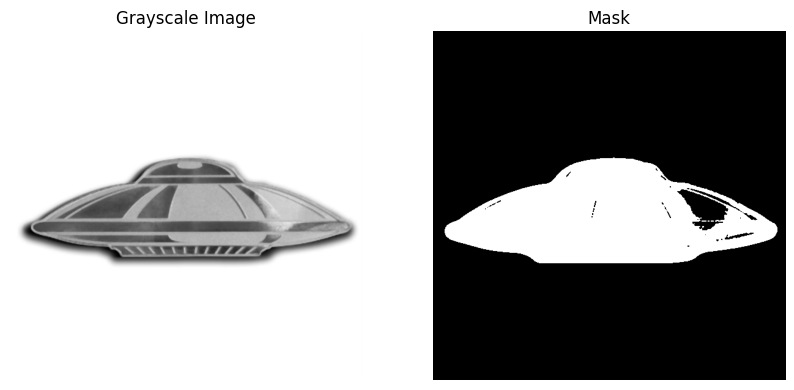

Маска збережена у файл mask1.png


In [10]:
# Завантаження зображення
image_path = "ufoo.png"
image = io.imread(image_path)

# Видалення альфа-канал, якщо він присутній
if image.shape[-1] == 4:
    image = image[..., :3]

# Перетворення зображення у відтінки сірого
image_gray = color.rgb2gray(image)

# Використання фільтр для покращення контрастності (необов'язково)
image_gray = filters.median(image_gray)

# Застосування порогову бінаризацію для створення маски
threshold = filters.threshold_otsu(image_gray)
mask = image_gray < threshold

# Візуалізація оригінальне зображення та маску
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

# Зберегти маску
mask_save_path = "mask1.png"
io.imsave(mask_save_path, (mask * 255).astype(np.uint8))
print(f"Маска збережена у файл {mask_save_path}")


In [11]:
def resize_mask(mask, scale):
    h, w = mask.shape[:2]
    new_h = int(h / scale)
    new_w = int(w / scale)
    resized_mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
    return resized_mask

In [12]:
# Фуекція клонування
def insert_cloned_masks(image, background, mask, alpha=0.5):
    num_masks = 4
    scaled_mask = mask.copy()
    scaled_image = image.copy()
    for _ in range(num_masks - 1):
        scaled_mask = resize_mask(scaled_mask, 2)
        scaled_image = cv2.resize(scaled_image, (scaled_mask.shape[1], scaled_mask.shape[0]))
    
    result_image = background.copy()
    h, w = image.shape[:2]
    mask_h, mask_w = scaled_mask.shape[:2]
    step_h = h // (num_masks // 2)
    step_w = w // (num_masks // 2)
    
    for i in range(num_masks // 2):
        for j in range(num_masks // 2):
            y_start = i * step_h
            y_end = min((i + 1) * step_h, h)
            x_start = j * step_w
            x_end = min((j + 1) * step_w, w)
            
            resized_mask = cv2.resize(scaled_mask, (x_end - x_start, y_end - y_start), interpolation=cv2.INTER_NEAREST)
            resized_image = cv2.resize(scaled_image, (x_end - x_start, y_end - y_start))
            
            # Get colors from the mask and insert them into the corresponding mask pixels
            colors = resized_image[resized_mask != 0]
            result_image_mask = result_image[y_start:y_end, x_start:x_end]
            result_image_mask[resized_mask != 0] = cv2.addWeighted(result_image_mask[resized_mask != 0], 1-alpha, colors, alpha, 0)
    
    return result_image

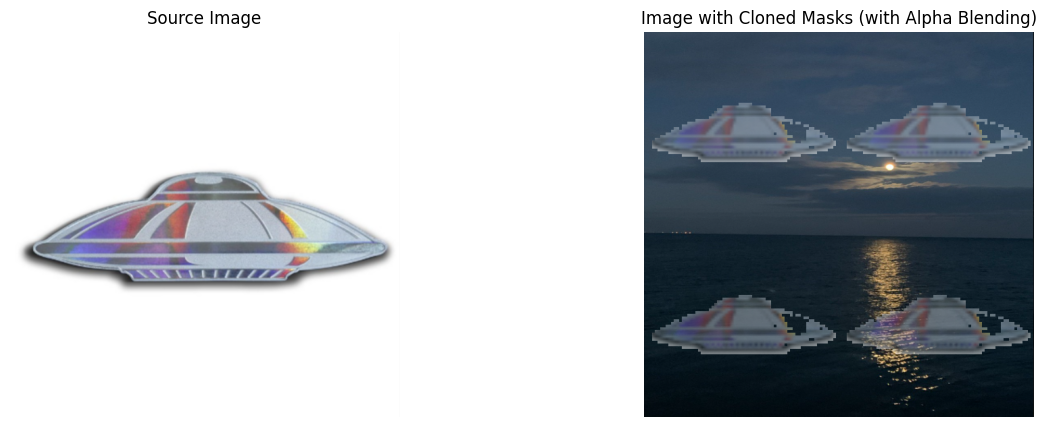

In [13]:
# Read input images
image = cv2.cvtColor(cv2.imread('ufoo.png'), cv2.COLOR_BGR2RGB)
background = cv2.cvtColor(cv2.imread('sea.png'), cv2.COLOR_BGR2RGB)
mask = cv2.imread('mask1.png', cv2.IMREAD_GRAYSCALE)

# Check the size of the mask and the image
if image.shape[:2] != mask.shape:
    # Resize the mask to match the size of the image
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Resize the background image to match the size of the image
background = cv2.resize(background, (image.shape[1], image.shape[0]))

# Insert cloned masks with alpha blending
result_image = insert_cloned_masks(image, background, mask, alpha=0.5)

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(image)
axs[0].set_title('Source Image')
axs[0].axis('off')
axs[1].imshow(result_image)
axs[1].set_title('Image with Cloned Masks (with Alpha Blending)')
axs[1].axis('off')

plt.show()
